<img align="left" src="https://www.taborelec.com/Pictures/logo.png">

# MARKER RISE TIME

### Test Description:
This script comes to demonstrate downloading markers to a Proteus device and test for marker waveform rise time.
This scripts supports connection via LAN and PXI

# Test Equipment
1. Tabor Proteus 9484M
2. Keysight Oscilloscope MSO9254A
3. 4 SMA to BNC Cable

# Hardware Connection
    Proteus Module    --->     Oscilloscope
    Channel 1         --->      Channel 1
    Channel 2         --->      Channel 2
    Channel 3         --->      Channel 3
    Channel 4         --->      Channel 4


# Test Procedure
1. Connect a channel to oscilloscope channel 1 and each marker separately and perform the test for all marker with respective channels individually.
2. Run the script and observe output on scope.

Proteus release - Aurora


In [1]:
##Parameters required
ip_address = '192.90.70.22'
FREQ = 2500
channb = 1
mrkr = 1
channel_on_scope = 1
mrkr_on_scope = 2

In [2]:
# a function that shows me the wave I created as f(x)
def plot(x,y):
    fig = plt.figure()   
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    # plot the function
    plt.plot(x,y, 'g')
    # show the plot
    plt.show()
    
# '''
# a function that build a squre wave with the following parameters: 
# @param  start_x: the start point of x 
# @param  end_x: the end point of x 
# @param How much points to create
# @param  end_x: How much cycles 
# @returns x and y     
# '''
# def prepare_squre_wave(start_x,end_x,num_points,cycle_num):
#     x = np.linspace(start_x, end_x, num_points , endpoint=False)
#     y = signal.square(2 * np.pi * cycle_num * x)
#     #plot(x,y)
#     return x,y  
    

In [3]:
## Import required Libraries
import os
import sys
import tempfile
import webbrowser
srcpath = os.path.realpath('..//..//SourceFiles')
sys.path.append(srcpath)
from teproteus import TEProteusAdmin as TepAdmin
from teproteus import TEProteusInst as TepInst
from teproteus_functions_v3 import connect
from teproteus_functions_v3 import disconnect
from teproteus_functions_v3 import set_lib_dir_path
from teproteus_functions_v3 import get_cpatured_header
from teproteus_functions_v3 import gauss_env
from teproteus_functions_v3 import iq_kernel
from teproteus_functions_v3 import pack_kernel_data
from teproteus import TEProteusAdmin, TEProteusInst
from tevisainst import TEVisaInst
# matplotlib notebook
import numpy as np
import time
import ipywidgets as widgets
from IPython.core.debugger import set_trace
from scipy.signal import chirp, sweep_poly
import matplotlib.pyplot as plt

plt.style.use('ggplot')
from scipy import signal
import math
import pdb

import pyvisa as visa
from pyvisa.errors import Error

# Connect Proteus 
inst = connect(ip_address)

# Get the instrument's *IDN
resp = inst.send_scpi_query('*IDN?')
print('Connected to: ' + resp)
inst.default_paranoia_level = 2
print ('Reset instrument ..')
paranoia_level=2
# Reset the instrument
inst.send_scpi_cmd( '*CLS; *RST', paranoia_level)
inst.send_scpi_cmd( ':TRACe:DELete:ALL', paranoia_level)
inst.send_scpi_cmd(":INIT:CONT ON")

# Get the model name
model = inst.send_scpi_query(":SYST:iNF:MODel?")
print("Model: " + model)

# Infer the natural DAC waveform format
if 'P908' in model:
    dac_mode = 8
else:
    dac_mode = 16
print("DAC waveform format: {0} bits-per-point".format(dac_mode))

# Get number of channels
resp = inst.send_scpi_query(":INST:CHAN? MAX")
print("Number of channels: " + resp)
num_channels = int(resp)

# Get the maximal number of segments
resp = inst.send_scpi_query(":TRACe:SELect:SEGMent? MAX")
print("Max segment number: " + resp)
max_seg_number = int(resp)

# Get the available memory in bytes of wavform-data (per DDR):
resp = inst.send_scpi_query(":TRACe:FREE?")
arbmem_capacity = int(resp)
print("Available memory per DDR: {0:,} wave-bytes".format(arbmem_capacity))

if dac_mode == 16:
    max_dac = 65535
    data_type = np.uint16 
else:
    max_dac = 255
    data_type = np.uint8 
    
half_dac = max_dac / 2.0 
resp = inst.send_scpi_query(':SYST:ERR?')
if not resp.startswith('0'):
    print("ERROR",resp)

Service connect
Trying to connect to IP:192.90.70.22
Connected to: Tabor Electronics,P9484M,000002232771,1.238.6 --Tabor Electronics,P9484M,000000000000,1.238.6 --slot#: 2, slot#: 4, 
Reset instrument ..
Model: P9484M
DAC waveform format: 16 bits-per-point
Number of channels: 4
Max segment number: 65536
Available memory per DDR: 17,171,480,576 wave-bytes


In [4]:
    
scope_addr2= 'USB0::0x2A8D::0x900E::MY55490134::INSTR'
# connect to scope via USB
try:
    resourceManager = visa.ResourceManager()   # Create a connection (session) to the instrument
    scope = resourceManager.open_resource(scope_addr2)
except visa.Error as ex2:
        print('Couldn\'t connect to \'%s\', exiting now...' % scope_addr2)
        sys.exit()
    ## scope acquisition 
# Send *IDN? and read the response
scope.write('*RST?')
scope.write('*IDN?')
idn = scope.read()
print('*IDN? returned: %s' % idn.rstrip('\n'))
#scope.write('*CLS;:DISPlay:CGRade:LEVels ')

*IDN? returned: KEYSIGHT TECHNOLOGIES,MSO9254A,MY55490134,06.40.01101


In [5]:
#FREQ = 2500
inst.send_scpi_cmd(":FREQ:RAST {0}MHz".format(FREQ))
resp = inst.send_scpi_query(":FREQ:RAST?")
freq = float(resp)/1e6
print ("DAC Generate Freq:{0}MHz".format(freq))
resp = inst.send_scpi_query(':SYST:ERR?')
if not resp.startswith('0'):
    print("ERROR",resp)

DAC Generate Freq:2500.0MHz


## Prepare waveform's and marker's data for segments


In [6]:
# Build wave-data and markers-data 
print('Build wave-data and markers-data ..')
seg_wave_points = 4096
ncycles =  1
cyclelen = seg_wave_points/ncycles

wave = [ None ]
mark = [ None ]

# Buffer size for the waveform
if dac_mode == 16:
    
    seg_wave_bytes = seg_wave_points * 2 # each point is 2 bytes in size
else:
    
    seg_wave_bytes = seg_wave_points

#seg_wave_bytes = seg_wave_points * 2 # each waveform point is represented as uint16 (2 bytes in size)

# Buffer size for Marker
if dac_mode == 16 and freq <= 2500000000:
    marker_cycle = 2
    seg_mark_bytes = seg_wave_points // 4
else:
    marker_cycle = 8
    seg_mark_bytes = seg_wave_points // 8

# Build wave
x = np.linspace(start=0, stop=seg_wave_points, num=seg_wave_points, endpoint=False)
yw = np.fmod(x, cyclelen)
yw = (yw <= cyclelen / 2) * max_dac
yw = np.round(yw)
yw = np.clip(yw, 0, max_dac)
yw = yw.astype(data_type)

yw.reshape(-1) # = yw.astype(data_type)

   
# Build marker  
x = np.linspace(
    start=0, stop=seg_mark_bytes, num=seg_mark_bytes, endpoint=False)
y = np.fmod(x, seg_mark_bytes)
y = (y <= seg_mark_bytes / 2) * 0x33
y = np.round(y)
y = np.clip(y, 0, 255)
# y= np.ones(seg_mark_bytes,np.uint8) *0xFF
mark = y

mark = y.astype(np.uint8).reshape(-1)

del x, y    
print('Done')    

Build wave-data and markers-data ..
Done


## Download waveform data to segments

In [7]:
# Download segments
# channb = 1
segnum = 1
wav = yw
mrk = mark

print('Download wave to segment {0} of channel {1}'.format(segnum, channb))
print('Number of wave point:{0}'.format(seg_wave_points))

# Select channel
inst.send_scpi_cmd( ':INST:CHAN {0}'.format(channb))

# Define segment
inst.send_scpi_cmd(  ':TRAC:DEF {0},{1}'.format(segnum, seg_wave_points))

# Select the segment
inst.send_scpi_cmd(':TRAC:SEL {0}'.format(segnum))

# Increase the timeout before writing binary-data:
inst.timeout = 30000

# Send the binary-data with *OPC? added to the beginning of its prefix.
#inst.write_binary_values('*OPC?; :TRAC:DATA', wav, datatype=wav_dat_type)
inst.write_binary_data(':TRAC:DATA', wav)

# Read the response to the *OPC? query that was added to the prefix of the binary data
#resp = inst.read()
# Set normal timeout
inst.timeout = 10000
resp = inst.send_scpi_query(':SYST:ERR?')
resp = resp.rstrip()
if not resp.startswith('0'):
    print('ERROR: "{0}" after writing binary values'.format(resp))
inst.send_scpi_cmd(':INST:CHAN 1')
inst.send_scpi_cmd('FUNC:MODE ARB')
# Play the specified segment at the selected channel
inst.send_scpi_cmd( ':SOUR:FUNC:MODE:SEGM {0}'.format(segnum))

resp = inst.send_scpi_cmd(':OUTP OFF')
inst.send_scpi_cmd(':SOUR:VOLT 0.5')
# Turn on the output of the selected channel:
resp = inst.send_scpi_cmd(':OUTP ON')
resp = inst.send_scpi_query(':SYST:ERR?')
resp = resp.rstrip()
if not resp.startswith('0'):
    print('ERROR: "{0}" after writing binary values'.format(resp))

Download wave to segment 1 of channel 1
Number of wave point:4096


## Download markers-data to segments 


In [8]:
print('Download markers to segment {0} of channel {1}'.format(segnum, channb))

# Increase the timeout before writing binary-data:
inst.timeout = 30000

# Send the binary-data with *OPC? added to the beginning of its prefix.
inst.send_scpi_cmd( ':INST:CHAN {0}'.format(channb))
inst.send_scpi_cmd( ':TRAC:SEL {0}'.format(segnum))
inst.write_binary_data(':MARK:DATA',mark)
inst.send_scpi_cmd(':MARK:SEL 1')
inst.send_scpi_cmd(':MARK:STAT ON')
# Read the response to the *OPC? query that was added to the prefix of the binary data
#resp = inst.read()
# Set normal timeout
inst.timeout = 10000
resp = inst.send_scpi_query(':SYST:ERR?')
resp = resp.rstrip()
if not resp.startswith('0'):
    print('ERROR: "{0}" after writing binary values'.format(resp))


Download markers to segment 1 of channel 1


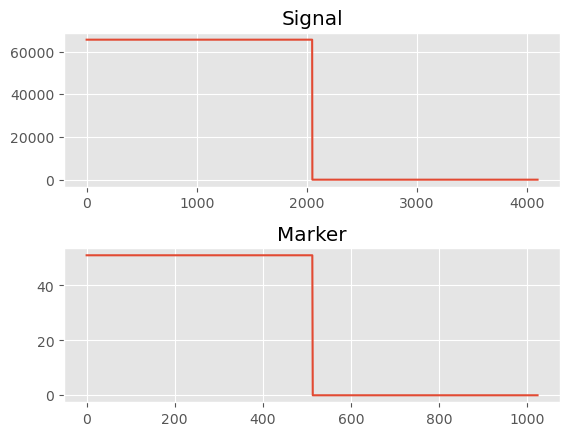

uint16


In [9]:
fig = plt.figure()
plt1 = fig.add_subplot(211)
plt2 = fig.add_subplot(212)
plt1.plot(yw)
plt1.set_title('Signal')
plt2.plot(mark)
plt2.set_title('Marker')
fig.subplots_adjust(hspace=.4,wspace=0.5)
plt.show()
print( yw.dtype)

## Play out marker's data

In [10]:
inst.send_scpi_cmd(':INST:CHAN {0}'.format(channb))
inst.send_scpi_cmd(':SOUR:VOLT 0.5')
inst.send_scpi_cmd(':SOUR:VOLT:OFFS 0')
inst.send_scpi_cmd(':MARK:SEL 1')
inst.send_scpi_cmd(':MARK:STAT ON')
inst.send_scpi_cmd(':MARK:VOLT:PTOP 0.5')
inst.send_scpi_cmd(':MARK:VOLT:OFFS 0')



0

# marker rise time fall time

In [13]:
test_success = True
vertical_scale_per_divison = 0.062
horizontal_scale_per_divison = 100e-12
riseFall_time = 200e-12
for i in range(4):
    for mrker in range(2):
        inst.send_scpi_cmd(':INST:CHAN {0}'.format(i+1))
        inst.send_scpi_cmd(':MARK:SEL {}'.format(mrker+1))
        channb = inst.send_scpi_query(':INST:CHAN?')
        mrker = inst.send_scpi_query(':MARK:SEL?')
        print('Connect Channel {0} Marker {1} to channel 1 and 2 of the oscilloscope\n Press enter '.format(channb,mrker))
        input()
        inst.send_scpi_cmd(':MARK:STAT ON')
        inst.send_scpi_cmd(':MARK:VOLT:PTOP 0.5')
        inst.send_scpi_cmd(':MARK:VOLT:OFFS 0')
        scope.write('*CLS;:DISPlay:CGRade:LEVels ')
        scope.write('*RST;:CHAN1:DISP OFF')
        scope.write(':CHAN{0}:DISP ON;:TIMebase:SCALe {1}'.format(mrkr_on_scope,horizontal_scale_per_divison))
        scope.write(':CHAN{0}:SCAL {1};:CHAN{0}:INP DC50'.format(mrkr_on_scope,vertical_scale_per_divison))
        #scope.write('*RST;:CHAN{0}:DISP ON;'.format(channel_on_scope,scope_time_scale))
        #scope.write('*RST;:CHAN{0}:DISP ON;:TIMebase:SCALe {1}'.format(channel_on_scope,horizontal_scale_per_divison))
        #scope.write('*RST;:CHAN{0}:DISP ON;:TIMebase:POS 1e-9'.format(channb,scope_time_scale))
        #[<source>[,<start_level>,<stop_level>]]
        time.sleep(1)
        scope.write(':MEASure:RISetime CHANnel{0},20,80'.format(mrkr_on_scope))
        time.sleep(2)
        scope.write(':MEASure:RESults?')
        result = scope.read()
        rise_time_temp= float(result.split(',')[1])
        print("Rise time :{}ps".format(rise_time_temp/1e-12))
        if rise_time_temp>riseFall_time:
            print("TEST FAILED for rise time on channel {} marker {}".format(channb,mrker))
        else:
            print("TEST PASSED for rise time on channel {} marker {}".format(channb,mrker))
        

Connect Channel 1 Marker 1 to channel 1 and 2 of the oscilloscope
 Press enter 

Rise time :256.41ps
TEST FAILED for rise time on channel 1 marker 1

Fall time :9.99999e+49ps
TEST FAILED for fall time on channel 1 marker 1
Connect Channel 1 Marker 2 to channel 1 and 2 of the oscilloscope
 Press enter 

Rise time :234.01000000000002ps
TEST FAILED for rise time on channel 1 marker 2

Fall time :9.99999e+49ps
TEST FAILED for fall time on channel 1 marker 2
Connect Channel 2 Marker 1 to channel 1 and 2 of the oscilloscope
 Press enter 

Rise time :246.88ps
TEST FAILED for rise time on channel 2 marker 1

Fall time :9.99999e+49ps
TEST FAILED for fall time on channel 2 marker 1
Connect Channel 2 Marker 2 to channel 1 and 2 of the oscilloscope
 Press enter 

Rise time :245.42000000000002ps
TEST FAILED for rise time on channel 2 marker 2

Fall time :9.99999e+49ps
TEST FAILED for fall time on channel 2 marker 2
Connect Channel 3 Marker 1 to channel 1 and 2 of the oscilloscope
 Press enter 

Ris

In [ ]:

disconnect()
scope.close()
# close connection
inst.close_instrument()